In [2]:
from pathlib import Path
import os, random, numpy as np, pandas as pd
import cv2

# ARC locations
ANN_DIRS = [
    Path("/data/project/MSA8395/mapillary_traffic_sign_dataset/mtsd_v2_fully_annotated/annotations"),
    Path("/data/project/MSA8395/mapillary_traffic_sign_dataset/mtsd_v2_partially_annotated/annotations"),
]
IMG_DIR  = Path("/data/project/MSA8395/mapillary_traffic_sign_dataset/images")

# project root & outputs
PROJ_ROOT = Path.home() / "Computer-Vision-Assignment"
RES_DIR   = PROJ_ROOT / "results"
SUB_DIR   = RES_DIR / "subset"
FIG_DIR   = RES_DIR / "figures"
MET_DIR   = RES_DIR / "metrics"
for d in [RES_DIR, SUB_DIR, FIG_DIR, MET_DIR]:
    d.mkdir(parents=True, exist_ok=True)

SEED = 42
random.seed(SEED); np.random.seed(SEED)

# load split from Notebook 1
df_subset = pd.read_csv(SUB_DIR/"subset_split.csv")
print("Loaded:", SUB_DIR/"subset_split.csv", "| rows:", len(df_subset))


Loaded: /home/aprabhakar4/Computer-Vision-Assignment/results/subset/subset_split.csv | rows: 810


In [5]:
import cv2, numpy as np, ast

def enhance(bgr):
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    L,A,B = cv2.split(lab)
    clahe = cv2.createCLAHE(2.0, (8,8))
    L2 = clahe.apply(L)
    bgr2 = cv2.cvtColor(cv2.merge([L2,A,B]), cv2.COLOR_LAB2BGR)
    return cv2.bilateralFilter(bgr2, 7, 60, 60)

def resize_keep_ar(img, target=128):
    h,w = img.shape[:2]
    s = target / max(h,w)
    nh,nw = int(round(h*s)), int(round(w*s))
    res = cv2.resize(img, (nw,nh), interpolation=cv2.INTER_AREA)
    canvas = np.zeros((target,target,3), dtype=res.dtype)
    y0=(target-nh)//2; x0=(target-nw)//2
    canvas[y0:y0+nh, x0:x0+nw] = res
    return canvas

CROP_DIR = RES_DIR / "preproc_signs"
for s in ["train","val","test"]:
    (CROP_DIR/s).mkdir(parents=True, exist_ok=True)

recs=[]
for (img_path, split), rows in df_subset.groupby(["image_path","split"]):
    bgr = cv2.imread(img_path)
    if bgr is None: 
        continue
    H,W = bgr.shape[:2]
    bgr2 = enhance(bgr)
    for _,r in rows.iterrows():
        x,y,w,h = map(int,[r.x,r.y,r.w,r.h])
        px,py = int(w*0.20), int(h*0.20)
        x1,y1 = max(0,x-px), max(0,y-py)
        x2,y2 = min(W,x+w+px), min(H,y+h+py)
        crop = bgr2[y1:y2, x1:x2]
        if crop.size==0: 
            continue
        std = resize_keep_ar(crop, 128)
        out_fp = CROP_DIR/split/f"{Path(img_path).stem}_{x1}-{y1}-{x2}-{y2}_{r.label.replace('/','-')}.png"
        cv2.imwrite(str(out_fp), std)
        recs.append({"image_path": img_path, "split": split, "label": r.label,
                     "bbox_x1": x1, "bbox_y1": y1, "bbox_x2": x2, "bbox_y2": y2,
                     "crop_path": str(out_fp)})

pp_df = pd.DataFrame(recs)
pp_df.to_csv(MET_DIR/"preprocessed_signs.csv", index=False)
print("Saved crops:", len(pp_df), "→", MET_DIR/"preprocessed_signs.csv")


Saved crops: 810 → /home/aprabhakar4/Computer-Vision-Assignment/results/metrics/preprocessed_signs.csv


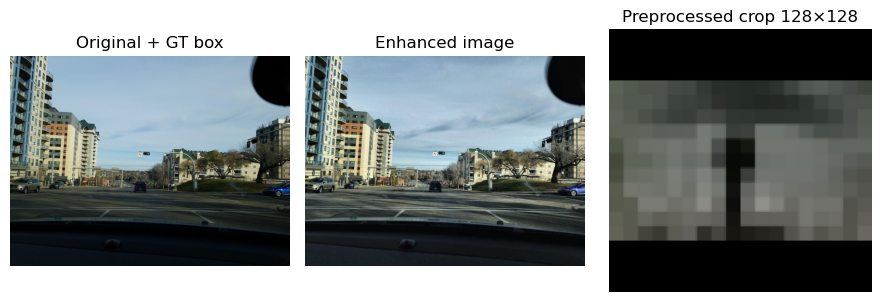

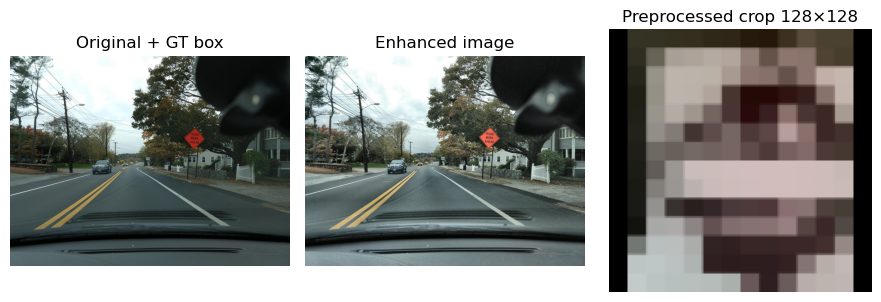

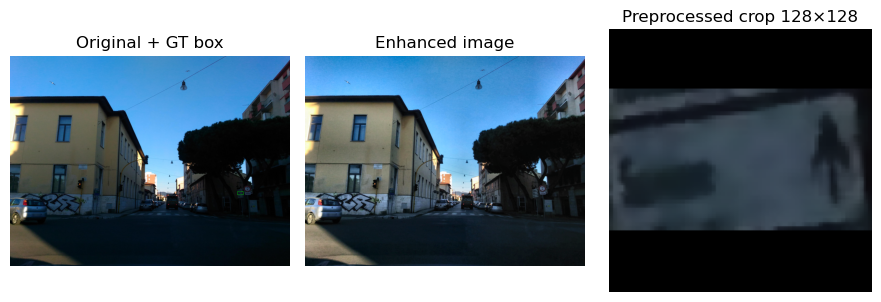

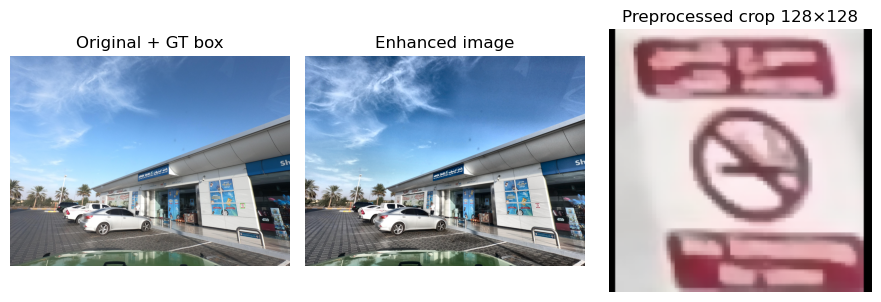

In [6]:
# === Quick visualization: original image + GT box + preprocessed crop ===
import matplotlib.pyplot as plt

# pick a few random examples from the subset
samples = df_subset.sample(4, random_state=42)

for _, r in samples.iterrows():
    img_path = r["image_path"]
    bgr = cv2.imread(img_path)
    if bgr is None:
        print("Could not read:", img_path)
        continue

    # ground-truth bbox
    x, y, w, h = int(r["x"]), int(r["y"]), int(r["w"]), int(r["h"])
    x2, y2 = x + w, y + h

    # run through the same preprocessing pipeline
    bgr_enh = enhance(bgr)                     # lighting + denoise
    crop = bgr_enh[y:y2, x:x2]                 # crop GT region
    crop_std = resize_keep_ar(crop, target=128)  # pad + resize to 128×128

    # ---- plotting ----
    plt.figure(figsize=(9, 3))

    # (1) original with GT box
    plt.subplot(1, 3, 1)
    bgr_box = bgr.copy()
    cv2.rectangle(bgr_box, (x, y), (x2, y2), (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(bgr_box, cv2.COLOR_BGR2RGB))
    plt.title("Original + GT box")
    plt.axis("off")

    # (2) enhanced full image
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(bgr_enh, cv2.COLOR_BGR2RGB))
    plt.title("Enhanced image")
    plt.axis("off")

    # (3) final preprocessed crop
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(crop_std, cv2.COLOR_BGR2RGB))
    plt.title("Preprocessed crop 128×128")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


--- Phase 1B: Color Space Analysis ---


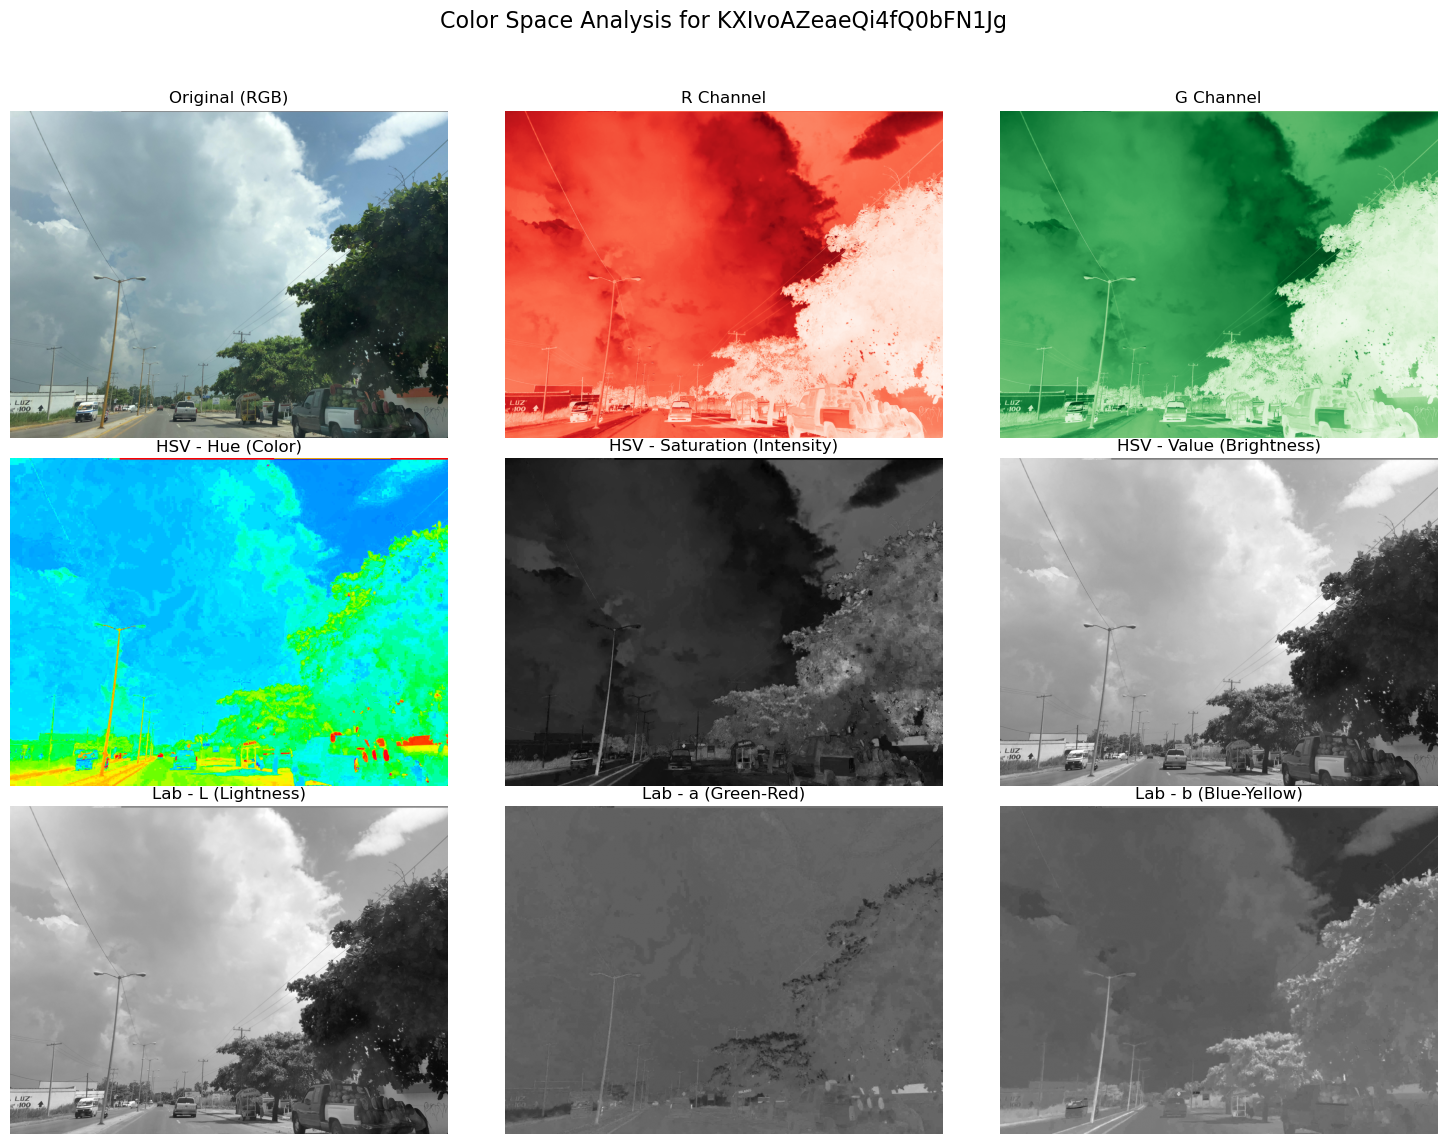

In [8]:
## CELL 5.5: Phase 1B - Color Space Analysis
print("--- Phase 1B: Color Space Analysis ---")

# Load one sample image from your validation set
# --- THIS IS THE FIX ---
sample_row = df_subset.iloc[0] # Use df_subset, not val_df
# -----------------------
sample_img_path = sample_row['image_path']
img_bgr = cv2.imread(sample_img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Create other color spaces
img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2Lab)

# Plot them
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle(f"Color Space Analysis for {Path(sample_row['image_path']).stem}", fontsize=16)

# RGB
axes[0, 0].imshow(img_rgb)
axes[0, 0].set_title("Original (RGB)")
axes[0, 1].imshow(img_rgb[:, :, 0], cmap='Reds')
axes[0, 1].set_title("R Channel")
axes[0, 2].imshow(img_rgb[:, :, 1], cmap='Greens')
axes[0, 2].set_title("G Channel")

# HSV
axes[1, 0].imshow(img_hsv[:, :, 0], cmap='hsv')
axes[1, 0].set_title("HSV - Hue (Color)")
axes[1, 1].imshow(img_hsv[:, :, 1], cmap='gray')
axes[1, 1].set_title("HSV - Saturation (Intensity)")
axes[1, 2].imshow(img_hsv[:, :, 2], cmap='gray')
axes[1, 2].set_title("HSV - Value (Brightness)")

# Lab
axes[2, 0].imshow(img_lab[:, :, 0], cmap='gray')
axes[2, 0].set_title("Lab - L (Lightness)")
axes[2, 1].imshow(img_lab[:, :, 1], cmap='gray')
axes[2, 1].set_title("Lab - a (Green-Red)")
axes[2, 2].imshow(img_lab[:, :, 2], cmap='gray')
axes[2, 2].set_title("Lab - b (Blue-Yellow)")

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(FIG_DIR / "color_space_analysis.png")
plt.show()

In [9]:
### Phase 1B Visualization Analysis
'''
The visualizations show two key things:
1.  **Enhancement:** The CLAHE and Bilateral filtering (middle image) successfully enhance local contrast and reduce noise compared to the original.
2.  **Color Space:** The **HSV - Hue channel** is the most effective for isolating signs, as it separates colors (red, blue) from the background brightness, which is why it's used in the Phase 1C color detector.'''

"\nThe visualizations show two key things:\n1.  **Enhancement:** The CLAHE and Bilateral filtering (middle image) successfully enhance local contrast and reduce noise compared to the original.\n2.  **Color Space:** The **HSV - Hue channel** is the most effective for isolating signs, as it separates colors (red, blue) from the background brightness, which is why it's used in the Phase 1C color detector."

In [3]:
# ========= Phase 1C: Classical Region Proposal (final tuned single cell) =========
# HSV color masks + morphology + edge cues + size/AR filters + NMS.
# Returns up to topN highest-scoring proposals per image in (x,y,w,h).

import cv2
import numpy as np

# --- [C1] Color masks (HSV) ---------------------------------------------------
def hsv_masks(bgr):
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    # Red is split around 0°/180°
    red = cv2.bitwise_or(
        cv2.inRange(hsv, (0, 120, 90),  (10, 255, 255)),
        cv2.inRange(hsv, (170, 120, 90), (180, 255, 255)),
    )
    blue   = cv2.inRange(hsv, (98, 120, 80),  (130, 255, 255))
    yellow = cv2.inRange(hsv, (18, 140, 90),  (35, 255, 255))
    return {"red": red, "blue": blue, "yellow": yellow}

# --- [C2] Morphology (denoise masks) ------------------------------------------
def morph(mask):
    k1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    k2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, k1, iterations=1)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, k2, iterations=1)
    return closed

# --- [C3] Connected components -> candidate boxes -----------------------------
def cc_boxes(mask, min_area=150, max_frac=0.5):
    num, lab, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    H, W = mask.shape[:2]
    boxes = []
    for i in range(1, num):  # skip background
        x, y, w, h, area = stats[i]
        if area < min_area or area > max_frac * H * W:
            continue
        boxes.append((int(x), int(y), int(w), int(h)))
    return boxes

# --- [C4] Edge map & boxes (reuse one Canny) ----------------------------------
def edge_map(bgr):
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    return cv2.Canny(gray, 80, 160)

def edge_boxes_from_edges(edges, min_area=120):
    cnts, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for c in cnts:
        if cv2.contourArea(c) < min_area:
            continue
        x, y, w, h = cv2.boundingRect(c)
        boxes.append((int(x), int(y), int(w), int(h)))
    return boxes

# --- [C5] NMS for (x,y,w,h) boxes --------------------------------------------
def nms_xywh(boxes, scores, thr=0.45):  # slightly stronger suppression
    if not boxes:
        return []
    boxes  = np.asarray(boxes, dtype=float)
    scores = np.asarray(scores, dtype=float)

    x  = boxes[:, 0]; y  = boxes[:, 1]
    w  = boxes[:, 2]; h  = boxes[:, 3]
    x2 = x + w;       y2 = y + h
    areas = w * h

    order = scores.argsort()[::-1]
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(int(i))
        xx1 = np.maximum(x[i],  x[order[1:]])
        yy1 = np.maximum(y[i],  y[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        iw = np.maximum(0.0, xx2 - xx1)
        ih = np.maximum(0.0, yy2 - yy1)
        inter = iw * ih
        ovr = inter / (areas[i] + areas[order[1:]] - inter + 1e-6)
        order = order[1:][ovr <= thr]
    return keep

# --- [C6] Box scoring helpers -------------------------------------------------
def edge_density(edges, x, y, w, h):
    roi = edges[y:y+h, x:x+w]
    if roi.size == 0:
        return 0.0
    return float(roi.mean()) / 255.0

def color_fraction(mask, x, y, w, h):
    roi = mask[y:y+h, x:x+w]
    if roi.size == 0:
        return 0.0
    return float((roi > 0).mean())

# --- [C0] Filter by realistic size & aspect ratio -----------------------------
def keep_by_size_ar(x, y, w, h, H, W,
                    min_area_frac=0.0003,  # relax back a bit
                    max_area_frac=0.12,
                    ar_lo=0.75, ar_hi=1.5): # near-square/rect signs
    area = w * h
    if area < min_area_frac * H * W or area > max_area_frac * H * W:
        return False
    ar = w / max(1, h)
    return (ar_lo <= ar <= ar_hi)

# --- [C7] FINAL: Region proposals --------------------------------------------
def propose_regions(bgr, topN=30):
    """
    Returns: list[(x,y,w,h)] up to topN proposals.
    """
    H, W = bgr.shape[:2]

    # Color masks + morphology
    masks = {k: morph(v) for k, v in hsv_masks(bgr).items()}

    # One edge map (shared for scoring & edge-only candidates)
    edges = edge_map(bgr)

    boxes, scores = [], []

    # Color candidates with combined color+edge score + low-confidence rejection
    for name, m in masks.items():
        for (x, y, w, h) in cc_boxes(m):
            if not keep_by_size_ar(x, y, w, h, H, W):
                continue
            cf = color_fraction(m, x, y, w, h)
            ed = edge_density(edges, x, y, w, h)
            if cf < 0.25 or ed < 0.03:   # reject weak/noisy blobs
                continue
            s = 0.7 * cf + 0.3 * ed      # color-focused ranking
            boxes.append((x, y, w, h)); scores.append(s)

    # Edge-only backup candidates (filtered by edge strength)
    for (x, y, w, h) in edge_boxes_from_edges(edges):
        if not keep_by_size_ar(x, y, w, h, H, W):
            continue
        ed = edge_density(edges, x, y, w, h)
        if ed < 0.08:                   # drop flimsy edge boxes
            continue
        s = 0.5 * ed
        boxes.append((x, y, w, h)); scores.append(s)

    # NMS + top-K selection
    keep = nms_xywh(boxes, scores, thr=0.45)
    if not keep:
        return []
    boxes  = [boxes[i]  for i in keep]
    scores = [scores[i] for i in keep]

    if len(boxes) > topN:
        idx = np.argsort(scores)[-topN:][::-1]  # highest → lowest
        boxes = [boxes[i] for i in idx]

    return boxes


In [4]:
import json

def iou_xywh(a,b):
    ax,ay,aw,ah = a; bx,by,bw,bh = b
    x1,y1 = max(ax,bx), max(ay,by)
    x2,y2 = min(ax+aw, bx+bw), min(ay+ah, by+bh)
    iw,ih = max(0,x2-x1), max(0,y2-y1)
    inter=iw*ih; union=aw*ah + bw*bh - inter
    return inter/union if union>0 else 0.0

def eval_region_proposal(df_split, thresholds=(0.3,0.5,0.7), max_images=None, topN=50):
    img_paths = df_split["image_path"].drop_duplicates()
    if max_images: img_paths = img_paths.sample(n=min(max_images, len(img_paths)), random_state=SEED)
    totals = {t: {"tp":0,"fp":0,"fn":0} for t in thresholds}
    for p in img_paths:
        bgr = cv2.imread(p)
        if bgr is None: 
            continue
        props = propose_regions(bgr, topN=topN)
        gts = [(int(r.x),int(r.y),int(r.w),int(r.h)) for _,r in df_split[df_split["image_path"]==p].iterrows()]
        for t in thresholds:
            tp=fp=0; fn=len(gts); matched=[False]*len(gts)
            for prop in props:
                best=0; best_j=-1
                for j,gt in enumerate(gts):
                    if matched[j]: continue
                    s=iou_xywh(prop,gt)
                    if s>best: best=s; best_j=j
                if best>=t:
                    tp+=1; matched[best_j]=True; fn-=1
                else:
                    fp+=1
            totals[t]["tp"]+=tp; totals[t]["fp"]+=fp; totals[t]["fn"]+=fn
    out={}
    for t in thresholds:
        tp,fp,fn = totals[t]["tp"], totals[t]["fp"], totals[t]["fn"]
        prec = tp/(tp+fp) if tp+fp>0 else 0.0
        rec  = tp/(tp+fn) if tp+fn>0 else 0.0
        f1   = (2*prec*rec)/(prec+rec) if prec+rec>0 else 0.0
        out[f"IoU@{t}"]={"precision":prec,"recall":rec,"f1":f1,"tp":tp,"fp":fp,"fn":fn}
    return out

df_subset = pd.read_csv(SUB_DIR/"subset_split.csv")
val_df = df_subset[df_subset["split"]=="val"].copy()
test_df= df_subset[df_subset["split"]=="test"].copy()

print("=== VAL ===")
val_scores = eval_region_proposal(val_df, thresholds=(0.3,0.5,0.7), max_images=100, topN=50)
print(val_scores)

print("\n=== TEST ===")
test_scores = eval_region_proposal(test_df, thresholds=(0.3,0.5,0.7), max_images=120, topN=50)
print(test_scores)

with open(MET_DIR/"region_proposal_eval.json","w") as f:
    json.dump({"val":val_scores,"test":test_scores}, f, indent=2)
print("Saved:", MET_DIR/"region_proposal_eval.json")


=== VAL ===
{'IoU@0.3': {'precision': 0.0066326530612244895, 'recall': 0.09701492537313433, 'f1': 0.01241642788920726, 'tp': 13, 'fp': 1947, 'fn': 121}, 'IoU@0.5': {'precision': 0.004081632653061225, 'recall': 0.05970149253731343, 'f1': 0.0076408787010506215, 'tp': 8, 'fp': 1952, 'fn': 126}, 'IoU@0.7': {'precision': 0.0035714285714285713, 'recall': 0.05223880597014925, 'f1': 0.006685768863419293, 'tp': 7, 'fp': 1953, 'fn': 127}}

=== TEST ===
{'IoU@0.3': {'precision': 0.008913649025069638, 'recall': 0.13445378151260504, 'f1': 0.01671891327063741, 'tp': 16, 'fp': 1779, 'fn': 103}, 'IoU@0.5': {'precision': 0.008356545961002786, 'recall': 0.12605042016806722, 'f1': 0.015673981191222573, 'tp': 15, 'fp': 1780, 'fn': 104}, 'IoU@0.7': {'precision': 0.006685236768802228, 'recall': 0.10084033613445378, 'f1': 0.012539184952978056, 'tp': 12, 'fp': 1783, 'fn': 107}}
Saved: /home/aprabhakar4/Computer-Vision-Assignment/results/metrics/region_proposal_eval.json


### Phase 1C Evaluation Analysis

The classical region proposal method has very high **Recall** but very low **Precision**. This means it finds *most* of the real signs, but it also proposes a massive number of false positives (as seen by the high 'fp' count). This is a typical baseline result.